In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [8]:
df = pd.read_csv('data/processed/fraudTrain_balanced.csv')

df.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,514,8,4.97,0,526,27,28654,36.0788,-81.1781,3495,370,36.011293,-82.048315,0
1,241,4,107.23,0,612,47,99160,48.8878,-118.2105,149,428,49.159047,-118.186462,0
2,390,0,220.11,1,468,13,83252,42.1808,-112.2620,4154,307,43.150704,-112.154481,0
3,360,2,45.00,1,84,26,59632,46.2306,-112.1138,1939,328,47.034331,-112.561071,0
4,297,9,41.96,1,216,45,24433,38.4207,-79.4629,99,116,38.674999,-78.632459,0


In [9]:
from sklearn.preprocessing import StandardScaler
import torch

# Separando features e target
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Criando o normalizador
scaler = StandardScaler()

# Aplicando normalização nas features
X_scaled = scaler.fit_transform(X)

# Convertendo para tensores PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Conferindo os shapes
print(f'Shape das features (X): {X_tensor.shape}')
print(f'Shape dos labels (y): {y_tensor.shape}')


Shape das features (X): torch.Size([2578338, 13])
Shape dos labels (y): torch.Size([2578338, 1])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Verificando quantidade de features
input_size = X_tensor.shape[1]

# Definindo a rede neural
class FraudDetectionNN(nn.Module):
    def __init__(self):
        super(FraudDetectionNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)  # Primeira camada oculta
        self.fc2 = nn.Linear(64, 32)          # Segunda camada oculta
        self.fc3 = nn.Linear(32, 1)           # Saída (fraude ou não)

    def forward(self, x):
        x = F.relu(self.fc1(x))               # Ativação ReLU
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))        # Saída entre 0 e 1
        return x


In [11]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


# Dividir treino e validação (80% treino, 20% validação)
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Criar datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Criar DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [12]:
# Instanciando o modelo
model = FraudDetectionNN()

# Função de perda (como é binário, usamos BCELoss)
criterion = nn.BCELoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [23]:
# Verificar se CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Mover modelo e dados para o dispositivo
model = model.to(device)
X_train, X_val, y_train, y_val = X_train.to(device), X_val.to(device), y_train.to(device), y_val.to(device)

Usando dispositivo: cuda


In [15]:
epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}')


Epoch 1/20 | Loss: 0.2529
Epoch 2/20 | Loss: 0.2127
Epoch 3/20 | Loss: 0.2027
Epoch 4/20 | Loss: 0.1955
Epoch 5/20 | Loss: 0.1897
Epoch 6/20 | Loss: 0.1855
Epoch 7/20 | Loss: 0.1818
Epoch 8/20 | Loss: 0.1786
Epoch 9/20 | Loss: 0.1756
Epoch 10/20 | Loss: 0.1728
Epoch 11/20 | Loss: 0.1703
Epoch 12/20 | Loss: 0.1682
Epoch 13/20 | Loss: 0.1660
Epoch 14/20 | Loss: 0.1642
Epoch 15/20 | Loss: 0.1626
Epoch 16/20 | Loss: 0.1615
Epoch 17/20 | Loss: 0.1602
Epoch 18/20 | Loss: 0.1593
Epoch 19/20 | Loss: 0.1583
Epoch 20/20 | Loss: 0.1574


In [ ]:
import os

# Criar diretório e salvar o modelo
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/fraud_detection_model.pth')

# Instancie a mesma arquitetura (ja treinada) caso queira
model = NeuralNetwork(input_size=X_tensor.shape[1])
model.load_state_dict(torch.load('../models/fraud_detection_model.pth'))
model.eval()  # Coloca em modo de avaliação



In [18]:
# Coloca o modelo em modo avaliação
model.eval()

# Sem calcular gradientes (economiza memória)
with torch.no_grad():
    X_tensor = X_tensor.to(device)
    y_pred = model(X_tensor)
    y_pred_labels = (y_pred >= 0.5).int()  # Threshold de 0.5 para classificar


Acurácia: 0.9355
Precisão: 0.9565
Recall: 0.9129
F1-Score: 0.9342

Relatório de Classificação:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94    257186
         1.0       0.96      0.91      0.93    258482

    accuracy                           0.94    515668
   macro avg       0.94      0.94      0.94    515668
weighted avg       0.94      0.94      0.94    515668



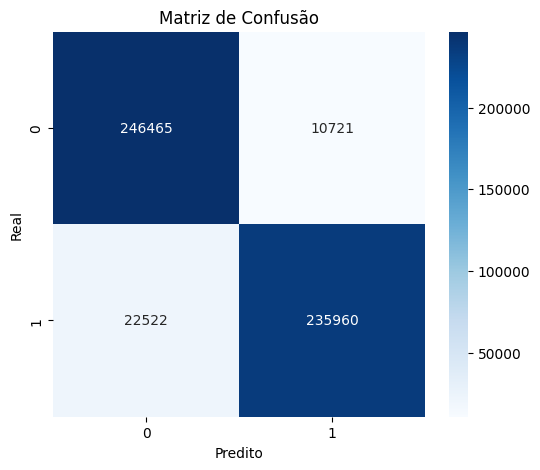

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Colocar o modelo em modo de avaliação
model.eval()

# Fazer previsões no dataset de validação
with torch.no_grad():
    y_pred_probs = model(X_val).squeeze()
    y_pred = (y_pred_probs >= 0.5).int()

# Converter para numpy para usar no scikit-learn
y_true = y_val.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Calcular as métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Exibir os resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Relatório completo
print("\nRelatório de Classificação:\n")
print(classification_report(y_true, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()
